# Deep learning for Natural Language Processing
## Павел Яковенко, гр. 295

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content

In [16]:
df = pd.read_csv("avito_train.tsv",sep='\t') 

In [4]:
print df.shape, df.is_blocked.mean()
df[:5]

(3995803, 13) 0.0688212106553


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000025,Услуги,Предложения услуг,Монтаж кровли,Выполняем монтаж кровли фальцевой ^p Тел:8@@P...,"{""Вид услуги"":""Ремонт, строительство""}",0,NaN,0,1,0,0,22.38
2,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
3,10000101,Транспорт,Автомобили с пробегом,"Ford Focus, 2011","Автомобиль в отличном техническом состоянии, в...","{""Марка"":""Ford"", ""Модель"":""Focus"", ""Год выпуск...",365000,NaN,0,0,0,0,8.87
4,10000132,Транспорт,Запчасти и аксессуары,Турбина 3.0 Bar,Продам турбину на двигатель V-6 . V-8 и мощнее...,"{""Вид товара"":""Запчасти"", ""Тип товара"":""Для ав...",5000,NaN,0,0,0,0,11.82


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [5]:
print "Blocked ratio", df.is_blocked.mean()
print "Count:", len(df)

Blocked ratio 0.0688212106553
Count: 3995803


# Balance-out the classes

In [6]:
#downsample
MAX_NOT_BLOCKED_ADS = len(df[df.is_blocked == True])

df_filtered = pd.concat([df[df.is_blocked == True], df[df.is_blocked == False][:MAX_NOT_BLOCKED_ADS]])


print "Blocked ratio:", df_filtered.is_blocked.mean()
print "Count:", len(df_filtered)

Blocked ratio: 0.5
Count: 549992


In [7]:
del df

In [8]:
assert df_filtered.is_blocked.mean() < 0.51
assert df_filtered.is_blocked.mean() > 0.49
assert len(df_filtered) <= 560000

print "All tests passed"

All tests passed


# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [11]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df_filtered.description.values, df_filtered.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

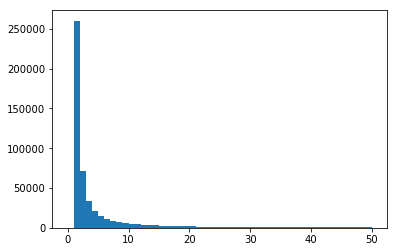

In [12]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [13]:
min_count = 10
tokens = [token for token, occur in token_counts.iteritems() if occur >= min_count]

In [14]:
token_to_id = {t: i + 1 for i, t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [15]:
print "# Tokens:", len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) > 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 87950


### Replace words with IDs

In [16]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [17]:
desc_tokens = vectorize(df_filtered.description.values, token_to_id, max_len = 150)
title_tokens = vectorize(df_filtered.title.values, token_to_id, max_len = 15)

### Data format examples


In [18]:
print u"Размер матрицы:", title_tokens.shape
for title, tokens in zip(df_filtered.title.values[:3], title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (549992, 15)
Поездки на таможню, печать в паспорте -> [43275 14651 55417 82139 80223 17327     0     0     0     0] ...
Рефлекторно-урогинекологический массаж -> [ 8340     0 30473     0     0     0     0     0     0     0] ...
Возьму суду под200 т. р -> [28819 23424     0  3628 33973     0     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences

In [19]:
#All numeric features
df_numerical_features = df_filtered[["phones_cnt","emails_cnt","urls_cnt","price"]]


In [20]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df_filtered[["category", "subcategory"]].values

categories = [
    {"category": category, "subcategory": subcategory} 
    for category, subcategory in data_cat_subcat
]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot, columns=vectorizer.feature_names_)

In [21]:
df_non_text = pd.merge(
    df_numerical_features, cat_one_hot, on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [109]:
#Target variable - whether or not sample contains prohibited material
target = df_filtered.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [110]:
assert target.shape[0] == title_tokens.shape[0] == desc_tokens.shape[0] == df_non_text.shape[0]

Я разбил на test/train в отношение 1/3, причем сделал это сбалансированно - и в обучающей, и в тестируемой выборке одинаковое количество плохих и хороших объявлений.

In [111]:
FACTOR = 0.75
SIZE = len(target)
TRAIN_SIZE_PER_ANSWER = int(FACTOR * SIZE / 2)
train_indexes_not_blocked = []
train_indexes_blocked = []
test_indexes_blocked = []
test_indexes_not_blocked = []
for i in xrange(SIZE):
    if target[i]:
        if len(train_indexes_blocked) < TRAIN_SIZE_PER_ANSWER:
            train_indexes_blocked.append(i)
        else:
            test_indexes_blocked.append(i)
    else:
        if len(train_indexes_not_blocked) < TRAIN_SIZE_PER_ANSWER:
            train_indexes_not_blocked.append(i)
        else:
            test_indexes_not_blocked.append(i)
            
train_indexes = train_indexes_blocked + train_indexes_not_blocked
test_indexes = test_indexes_blocked + test_indexes_not_blocked

In [112]:
assert len(test_indexes) + len(train_indexes) == SIZE
assert len(train_indexes) == int(SIZE * FACTOR)

In [113]:
title_tr, title_ts = title_tokens[train_indexes], title_tokens[test_indexes]
desc_tr, desc_ts = desc_tokens[train_indexes], desc_tokens[test_indexes] 
nontext_tr, nontext_ts = df_non_text.as_matrix()[train_indexes], df_non_text.as_matrix()[test_indexes]
target_tr, target_ts = target[train_indexes], target[test_indexes]

## Save preprocessed data 

In [1]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    data_tuple = title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple, fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id, fout)

    print "done"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print "done"        

Reading saved data...
done


# Train NN

In [2]:
#libraries
import lasagne
from theano import tensor as T
import theano

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: Tesla K40m (CNMeM is disabled, cuDNN 5005)


Я не стал использовать категориальные и численные признаки.

In [3]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids", dtype='int32')
desc_token_ids = T.matrix("desc_token_ids", dtype='int32')
target_y = T.ivector("is_blocked")

# NN architecture

In [4]:
title_inp = lasagne.layers.InputLayer((None, title_tr.shape[1]), input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None, desc_tr.shape[1]), input_var=desc_token_ids)

Просто один embedding и над ним RNN.

In [5]:
# Descriptions

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id) + 1, output_size=128)
descr_nn = lasagne.layers.RecurrentLayer(descr_nn, num_units=512)

# Titles
title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id) + 1, output_size=128)
title_nn = lasagne.layers.RecurrentLayer(title_nn, num_units=512)

Объединяем слои, добавляем нормализатор и дропаут. Выход - один ответ, вероятность объявлению "быть плохим".

In [6]:
nn = lasagne.layers.ConcatLayer([descr_nn, title_nn]) 

nn = lasagne.layers.DenseLayer(nn, 4096)
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.DropoutLayer(nn, p=0.5)
nn = lasagne.layers.DenseLayer(nn, 1, nonlinearity=lasagne.nonlinearities.sigmoid)

# Loss function
Использовал hinge loss с стандартными параметрами.

In [7]:
#All trainable params
weights = lasagne.layers.get_all_params(nn, trainable=True)

In [8]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:, 0]

#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction, target_y, log_odds=False).mean()

In [9]:
#Weight optimization step
updates = lasagne.updates.nesterov_momentum(loss, weights, learning_rate=0.01)

### Determinitic prediction 

In [10]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:, 0]

#equivalent loss function
det_loss = lasagne.objectives.binary_hinge_loss(prediction, target_y, log_odds=False).mean()

### Coffee-lation

In [11]:
train_fun = theano.function([desc_token_ids, title_token_ids, target_y],[loss, prediction], updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,target_y],[det_loss, det_prediction])

# Training loop

In [12]:
from oracle import APatK, score

In [17]:
def iterate_minibatches(*arrays, **kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

Границу разделения верояности(вероятность "быть плохим" больше границы -- объявление плохое) задал равным 0.5.

In [14]:
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
import time

n_epochs = 5
batch_size = 100
minibatches_per_epoch = 100
BORDER = 0.5

for i in range(n_epochs):
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    start_time = time.time()
    for j, (b_desc, b_title, b_y) in enumerate(
        iterate_minibatches(desc_tr, title_tr, target_tr, batchsize=batch_size, shuffle=True)):
        
        if j > minibatches_per_epoch:
            break
            
        loss, pred_probas = train_fun(b_desc, b_title, b_y)
        
        b_loss += loss
        b_c += 1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    train_loss = b_loss / b_c
    try:    
        print "Train:"
        print '\tloss:', train_loss
        print '\tacc:', accuracy_score(epoch_y_true, epoch_y_pred > BORDER)
        print '\tauc:', roc_auc_score(epoch_y_true,epoch_y_pred)
        print '\tap@k:', APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    except Exception as e:
        print e
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc, b_title, b_y) in enumerate(
        iterate_minibatches(desc_ts, title_ts, target_ts, batchsize=batch_size, shuffle=True)):
        
        if j > minibatches_per_epoch:
            break
        
        loss, pred_probas = eval_fun(b_desc, b_title, b_y)
        
        b_loss += loss
        b_c += 1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    val_loss = b_loss / b_c
    
    try:    
        print "Validation:"
        print '\tloss:',b_loss/b_c
        print '\tacc:', accuracy_score(epoch_y_true, epoch_y_pred > BORDER)
        print '\tauc:', roc_auc_score(epoch_y_true,epoch_y_pred)
        print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    except Exception as e:
        print e
    
    
    print("Epoch {} of {} took {:.3f}s".format(
        i + 1, n_epochs, time.time() - start_time))
    
    if train_loss < val_loss and abs(train_loss - val_loss) > 0.05 and i >= n_epochs / 2:
        print "Break by diff in losses"
        break

Train:
	loss: 0.573809485431
	acc: 0.747920792079
	auc: 0.843282146167
	ap@k: 0.999376391166
Validation:
	loss: 0.360201027401
	acc: 0.849405940594
	auc: 0.929378770386
	ap@k: 1.0
Epoch 1 of 5 took 44.991s
Train:
	loss: 0.308707235431
	acc: 0.87297029703
	auc: 0.947780470389
	ap@k: 1.0
Validation:
	loss: 0.277203640908
	acc: 0.889306930693
	auc: 0.959505402049
	ap@k: 0.990610402034
Epoch 2 of 5 took 44.940s
Train:
	loss: 0.259469711594
	acc: 0.895940594059
	auc: 0.961258493952
	ap@k: 0.996459332138
Validation:
	loss: 0.288446915129
	acc: 0.884554455446
	auc: 0.955100216273
	ap@k: 0.991629930339
Epoch 3 of 5 took 44.826s
Train:
	loss: 0.245325669244
	acc: 0.904257425743
	auc: 0.964001684698
	ap@k: 0.988981492857
Validation:
	loss: 0.225180011996
	acc: 0.913762376238
	auc: 0.970719303752
	ap@k: 1.0
Epoch 4 of 5 took 44.801s
Train:
	loss: 0.206178736395
	acc: 0.919306930693
	auc: 0.974153742381
	ap@k: 1.0
Validation:
	loss: 0.234556042184
	acc: 0.911386138614
	auc: 0.969066277448
	ap@k: 1

# Final evaluation
5 эпох было достаточно.

In [15]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc, b_title, b_y) in enumerate(
    iterate_minibatches(desc_ts, title_ts, target_ts, batchsize=batch_size, shuffle=True)):
    loss, pred_probas = eval_fun(b_desc, b_title, b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true, epoch_y_pred > BORDER)
final_auc = roc_auc_score(epoch_y_true, epoch_y_pred)
final_apatk = APatK(epoch_y_true, epoch_y_pred, K = int(len(epoch_y_pred)*0.025) + 1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.230350272295
	acc: 0.911397379913
	auc: 0.969878387086
	ap@k: 0.996086964963

AUC:
	Сойдёт, хотя можно ещё поднажать (ok)

Accuracy:
	Всё ок (ok)

Average precision at K:
	Засабмить на kaggle! (great) 
	 Нет, ну честно - выкачай avito_test.tsv, засабмить и скажи, что вышло.



We Are Watching You!
                                                      .             ..                           
                                    .      ...;c:,::..  '  ':oococ:. ..                          
                              ..    .':dodxkkxxxxxxxkxddxkkkkkkkkkxkkdl:.                        
                             .'':lodxxxdxxxxxddxxddodddxkkxdxxxxxxxxxxxxk:d;,.                   
                          .;dxkxxxxxxxxk000Okdooooooloodxxdddxxkkxxddddodkkkkd'  .               
                       .:lkkkkkkkkkkkOOOkkxxxxdollllllloooddxxkOOOOkxdddldkkkOxc.                
                     .lkkkOOOkkkkOOOkkxdollcccccccccccccccllddxkOOOOkddddddxxxddd;.              
                   .cxkkOOOOOOOOkkkdolc:::;;;;;;;;;;;;;::::ccclodxkOOxddooodddooodo'             
                  ,dxkkOOOOOOOOkxolc::;;;;;;;;;;;;;;;;;;;;::::cclodxkkxddooolooollooc..          
                 ,xxkkkOOO0OOkxdol:;;;;;;,,,,;;;;;;;;;;;;;;;;;::ccloxxxxdoooollllollod,         